In [ ]:
pip install git+https://github.com/stefanradev93/bayesflow

Attention: Restart the runtime after installing bayesflow

# Import

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
from scipy import stats
import pickle

import tensorflow as tf


from tqdm import tqdm
from scipy.integrate import solve_ivp
import pickle

from sklearn.metrics import mean_squared_error
import time

In [2]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd

import bayesflow.diagnostics as diag
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d

/usr/local/lib/python3.10/dist-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm






# **Generative Model Setup**

In [ ]:
def ode_system(t, y, D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0):
  N,I,E,D = y
  Nt_dt = (N0 * (1+(I**p/(I0**p+I**p)))) - (kc * N * D) - (kt * N * D_ext) - gamma * N
  It_dt = (kt * N * D_ext) - (gamma_I * I)
  Et_dt = (1 * (I**p/(I0**p+I**p))) - (gamma * E)
  Dt_dt = (D0 * (I0**p/(I0**p+I**p))) - (kc*N*D) - (kt * N_ext * D) - (gamma * D)
  return [Nt_dt, It_dt, Et_dt, Dt_dt]

In [ ]:
def Nonlinear_Solver(params, T, p = 2,
                     kc = 5.e-4,kt = 5.e-5,
                     gamma = 0.1,gamma_I = 0.5,
                     N0 = 500,I0 = 200, E0 = 1, D0 = 1000,
                     scale_I = 100, scale_N = 1000, scale_E = 0.25, scale_D = 3000):
  """Performs a forward simulation with LSODA method using solve_ivp for the Nonlinear ODE model given a random draw from the prior,"""
  # Extract parameters
  N_ext = params[0]
  D_ext = params[1]
  # Initial conditions
  initial_cond = [params[2],params[3],params[4],params[5]]
  # Simulate T+1 timesteps
  time = (0,T)
  solution = solve_ivp(ode_system,time, initial_cond, method='LSODA', args=(D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0),max_step=0.01)
  t = solution.t
  N_sol, I_sol, E_sol, D_sol = solution.y
  #return np.stack([N_sol/scale_N, I_sol/scale_I, E_sol/scale_E, D_sol/scale_D])
  return np.stack([N_sol, I_sol, E_sol, D_sol])

One Step Simulation

1. simulate data with restricted initial condition

In [34]:
def prior_sample(Initial, Initial_Params = True):
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """

    N_ext = np.random.uniform(500,5500)
    D_ext = np.random.uniform(2500,3300)
    if Initial_Params:
      N_0 = 1000
      I_0 = 0
      E_0 = 0
      D_0 = 3000
    else:
      N_0 = Initial[0]
      I_0 = Initial[1]
      E_0 = Initial[2]
      D_0 = Initial[3]
    params = np.array([N_ext, D_ext, N_0, I_0, E_0, D_0])
    params = np.reshape(params,(1,6))
    return np.ceil(params)

In [ ]:
def simulate(N,T,N_time_steps):
  inital_conditions = np.zeros((4,))
  data = {}
  data['Prior'] = np.ndarray((0,6))
  data['next_step'] = np.ndarray((0,4))
  for i in range(N):
    prior = prior_sample(inital_conditions)
    data['Prior'] = np.concatenate((data['Prior'], prior), axis=0)
    TS = Nonlinear_Solver(prior[0],T)[:,-1].reshape((1,4))
    data['next_step'] = np.concatenate((data['next_step'],TS), axis=0)
  for i in tqdm(range(N_time_steps-1)):
    for p in range(N):
      inital_conditions = data['next_step'][p+i*N]
      prior = prior_sample(inital_conditions, Initial_Params = False)
      data['Prior'] = np.concatenate((data['Prior'], prior), axis=0)
      TS = Nonlinear_Solver(prior[0],T)[:,-1].reshape((1,4))
      data['next_step'] = np.concatenate((data['next_step'],TS), axis=0)
  return data

In [ ]:
def data_generator(batch_size, T):

  """
  This is for online training:

  Runs the forward model 'batch_size' times by first sampling fromt the prior
  theta ~ p(theta) and running x ~ p(x|theta).
  ----------

  Arguments:
  batch_size : int -- the number of samples to draw from the prior
  ----------

  Output:
  forward_dict : dict
      The expected outputs for a BayesFlow pipeline
  """

  # Generate data
  data = simulate(batch_size//32,T,32)
  forward_dict = {"prior_draws": data['Prior'], "sim_data": np.transpose(data['Time_Series'], axes=[0, 2, 1])}
  return forward_dict

In [ ]:
# Set generative function for online training
generative_model = partial(data_generator, T=10)

In [ ]:
# Simulating data for offline training
T = 10
data = simulate(70400//32,T,32)

In [ ]:
# save dictionary
with open('/content/drive/MyDrive/Team_Project/Simulated_Data/One_Step_Simulated_Data.pkl', 'wb') as fp:
    pickle.dump(data, fp)

In [ ]:
# Read dictionary pkl file
with open('/content/drive/MyDrive/Team_Project/Simulated_Data/One_Step_Simulated_Data.pkl', 'rb') as fp:
    d = pickle.load(fp)

2. Simulate data with random initial conditions

In [ ]:
def prior_sample_dis():

    N_ext = np.random.uniform(500,5500)
    D_ext = np.random.uniform(2500,3300)
    N_0 = np.random.uniform(380,4500)
    I_0 = np.random.uniform(0,1500)
    E_0 = np.random.uniform(0,10)
    D_0 = np.random.uniform(10,3000)
    params = np.array([N_ext, D_ext, N_0, I_0, E_0, D_0])
    params = np.reshape(params,(1,6))
    return np.ceil(params)

In [ ]:
def simulate_dis(N,T):
  inital_conditions = np.zeros((4,))
  data = {}
  data['Prior'] = np.ndarray((0,6))
  data['next_step'] = np.ndarray((0,4))
  for i in tqdm(range(N)):
    prior = prior_sample_dis()
    data['Prior'] = np.concatenate((data['Prior'], prior), axis=0)
    TS = Nonlinear_Solver(prior[0],T)[:,-1].reshape((1,4))
    data['next_step'] = np.concatenate((data['next_step'],TS), axis=0)
  return data

In [ ]:
T = 10
data = simulate_dis(70400,T)

100%|██████████| 70400/70400 [49:48<00:00, 23.56it/s]


In [ ]:
# save dictionary
with open('Simulated_Data/One_Step_Simulated_Data_Dist.pkl', 'wb') as fp:
    pickle.dump(data, fp)

In [3]:
# Read dictionary pkl file
with open('Simulated_Data/One_Step_Simulated_Data_Dist.pkl', 'rb') as fp:
    d = pickle.load(fp)

setting the train set

In [4]:
training_data = {}
training_data['prior_draws'] = d['next_step'][3200:67200]
training_data['sim_data'] = d['Prior'][3200:67200]

# Amortizer and Trainer

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

In [5]:
# No summary net, mock
summary_net = lambda x, **kwargs: x

# Robust inference with a Student-T latent
latent_dist_p = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*4, scale=tf.linalg.LinearOperatorDiag([1.]*4))
latent_dist_l = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*6, scale=tf.linalg.LinearOperatorDiag([1.]*6))


coupling_settings = {
    'affine': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        'dropout_prob': 0.05
    },
    'spline': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        'dropout_prob': 0.05
    }
}

# Inference networks
inference_net_p = InvertibleNetwork(
    num_params=4,
    num_coupling_layers=4,
    coupling_design='interleaved',
    coupling_settings=coupling_settings
)

inference_net_l = InvertibleNetwork(
    num_params=6,
    num_coupling_layers=8,
    coupling_design='interleaved',
    coupling_settings=coupling_settings,
)

# Amortizers
amortized_posterior = AmortizedPosterior(
    inference_net=inference_net_p,
    summary_net=summary_net,
    latent_dist=latent_dist_p
)

amortized_likelihood = AmortizedLikelihood(
    surrogate_net=inference_net_l,
    latent_dist=latent_dist_l
)

amortizer = AmortizedPosteriorLikelihood(
    amortized_posterior,
    amortized_likelihood
)

In [6]:
def _config_posterior(forward_dict):
    """Helper function for posterior configuration."""

    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"].astype(np.float32)
    input_dict["direct_conditions"] = forward_dict["sim_data"].astype(np.float32)
    return input_dict


def _config_likelihood(forward_dict):
    """Helper function for likelihood configuration."""

    input_dict = {}
    input_dict["conditions"] = forward_dict["prior_draws"].astype(np.float32)
    input_dict["observables"] = forward_dict["sim_data"].astype(np.float32)
    return input_dict

def configurator(forward_dict, mode = "joint"):
    """Configures simulator outputs for use in BayesFlow training."""

    # Case only posterior configuration
    if mode == "posterior":
        input_dict = _config_posterior(forward_dict)

    # Case only plikelihood configuration
    elif mode == "likelihood":
        input_dict = _config_likelihood(forward_dict)

    # Case posterior and likelihood configuration (i.e., joint inference)
    elif mode == "joint":
        input_dict = {}
        input_dict["posterior_inputs"] = _config_posterior(forward_dict)
        input_dict["likelihood_inputs"] = _config_likelihood(forward_dict)

    # Throw otherwise
    else:
        raise NotImplementedError('For now, only a choice between ["posterior", "likelihood", "joint"] is available!')
    return input_dict

In [7]:
initial_learning_rate = 0.005

trainer = Trainer(
    amortizer=amortizer,
    default_lr=initial_learning_rate,
    configurator=configurator,
)

# decay_steps = 500
num_sim = training_data['sim_data'].shape[0]
batch_size = 64
## calculate number of epochs needed to get desired number of iterations
# epochs = decay_steps // (num_sim // batch_size)


INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


Training

In [ ]:
losses = trainer.train_offline(training_data, epochs=25, batch_size=batch_size)

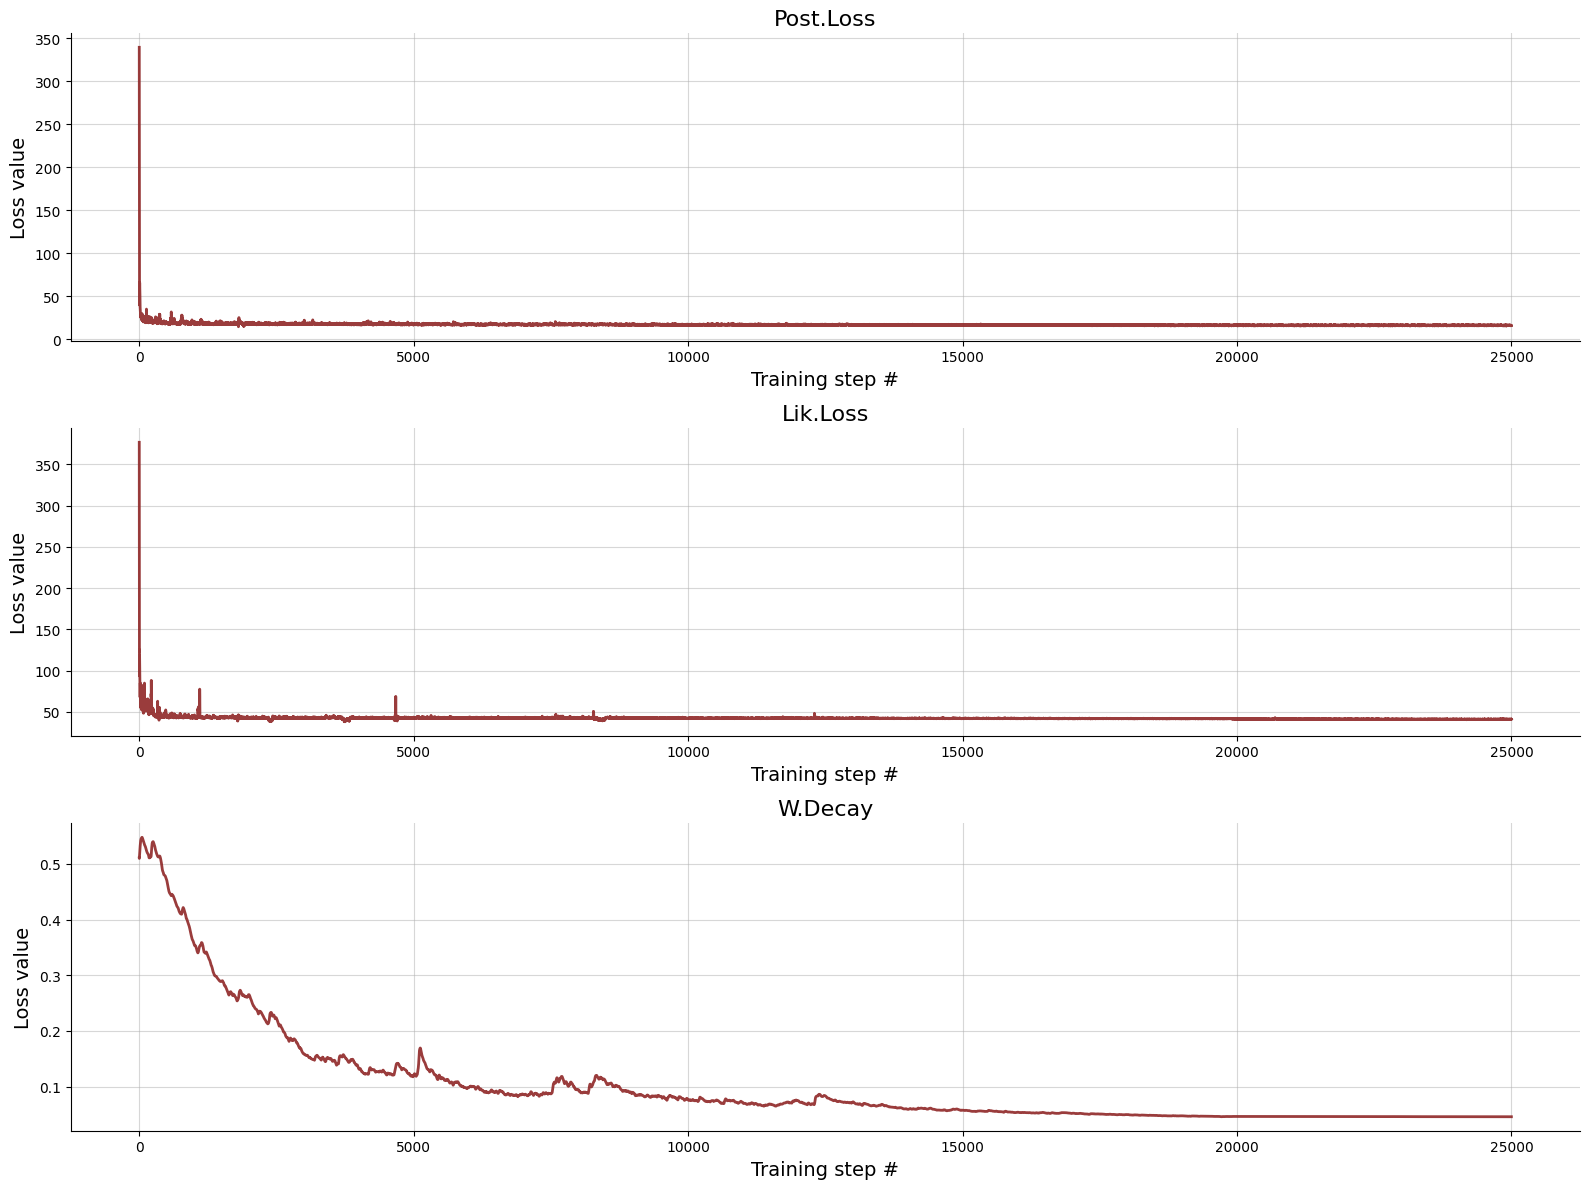

In [9]:
fig = diag.plot_losses(losses)

Validation

In [10]:
valid_data = {}

valid_data['prior_draws'] = np.concatenate((d['next_step'][0:3200],d['next_step'][67200:70400]),axis = 0)
valid_data['sim_data'] = np.concatenate((d['Prior'][0:3200],d['Prior'][67200:70400]), axis =0)

In [19]:
test_dict = {}
test_dict["direct_conditions"] = tf.convert_to_tensor(
    valid_data['sim_data'], dtype=float, dtype_hint=None, name=None
)
test_dict['training'] = 'False'

In [20]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_parameters(test_dict, n_samples=1, to_numpy = True )
x_sim_s = np.squeeze(x_sim_s)


# Test

In [23]:
N_ext = 3000
D_ext = 2700
Initial = [N_ext, D_ext, 1000 , 3, 2, 450]

In [24]:
def prior_sample_test(Initial):

    N_ext = Initial[0]
    D_ext = Initial[1]
    N_0 = Initial[2]
    I_0 = Initial[3]
    E_0 = Initial[4]
    D_0 = Initial[5]
    params = np.array([N_ext, D_ext, N_0, I_0, E_0, D_0])
    params = np.reshape(params,(1,6))
    return np.ceil(params)

In [25]:
def ode_system(t, y, D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0):
  N,I,E,D = y
  Nt_dt = (N0 * (1+(I**p/(I0**p+I**p)))) - (kc * N * D) - (kt * N * D_ext) - gamma * N
  It_dt = (kt * N * D_ext) - (gamma_I * I)
  Et_dt = (1 * (I**p/(I0**p+I**p))) - (gamma * E)
  Dt_dt = (D0 * (I0**p/(I0**p+I**p))) - (kc*N*D) - (kt * N_ext * D) - (gamma * D)
  return [Nt_dt, It_dt, Et_dt, Dt_dt]

In [26]:
def Nonlinear_Solver(params, T, p = 2,
                     kc = 5.e-4,kt = 5.e-5,
                     gamma = 0.1,gamma_I = 0.5,
                     N0 = 500,I0 = 200, E0 = 1, D0 = 1000,
                     scale_I = 100, scale_N = 1000, scale_E = 0.25, scale_D = 3000):
  """Performs a forward simulation with LSODA method using solve_ivp for the Nonlinear ODE model given a random draw from the prior,"""
  # Extract parameters
  N_ext = params[0]
  D_ext = params[1]
  # Initial conditions
  initial_cond = [params[2],params[3],params[4],params[5]]
  # Simulate T+1 timesteps
  time = (0,T)
  solution = solve_ivp(ode_system,time, initial_cond, method='LSODA', args=(D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0),max_step=0.01)
  t = solution.t
  N_sol, I_sol, E_sol, D_sol = solution.y
  #return np.stack([N_sol/scale_N, I_sol/scale_I, E_sol/scale_E, D_sol/scale_D])
  return np.stack([N_sol, I_sol, E_sol, D_sol])

In [27]:
def test_simulate(N,T,N_time_steps):
  data = {}
  data['Prior'] = np.ndarray((0,6))
  data['next_step'] = np.ndarray((0,4))
  inital_conditions = Initial
  for i in range(N):
    prior = prior_sample_test(inital_conditions)
    data['Prior'] = np.concatenate((data['Prior'], prior), axis=0)
    TS = Nonlinear_Solver(prior[0],T)[:,-1].reshape((1,4))
    data['next_step'] = np.concatenate((data['next_step'],TS), axis=0)
  for i in tqdm(range(N_time_steps-1)):
    for p in range(N):
      inital_conditions = np.concatenate((np.array([N_ext,D_ext]),data['next_step'][p+i*N]), axis = -1)
      prior = prior_sample_test(inital_conditions)
      data['Prior'] = np.concatenate((data['Prior'], prior), axis=0)
      TS = Nonlinear_Solver(prior[0],T)[:,-1].reshape((1,4))
      data['next_step'] = np.concatenate((data['next_step'],TS), axis=0)
  return data

In [28]:
T = 10
Test_data = test_simulate(1,T,32)
Test_data['Real_Time_Series'] = Nonlinear_Solver(prior_sample_test(Initial)[0],320)

100%|██████████| 31/31 [00:01<00:00, 23.67it/s]


In [29]:
test_dict = {}
test_dict["direct_conditions"] = tf.convert_to_tensor(
    Test_data['Prior'], dtype=float, dtype_hint=None, name=None
)
test_dict['training'] = 'False'

In [30]:
x_sim_s = amortizer.sample_parameters(test_dict, n_samples=100, to_numpy = True )
x_sim_s = np.nan_to_num(x_sim_s)
x_sim_s = np.squeeze(np.mean(x_sim_s,axis = 1))

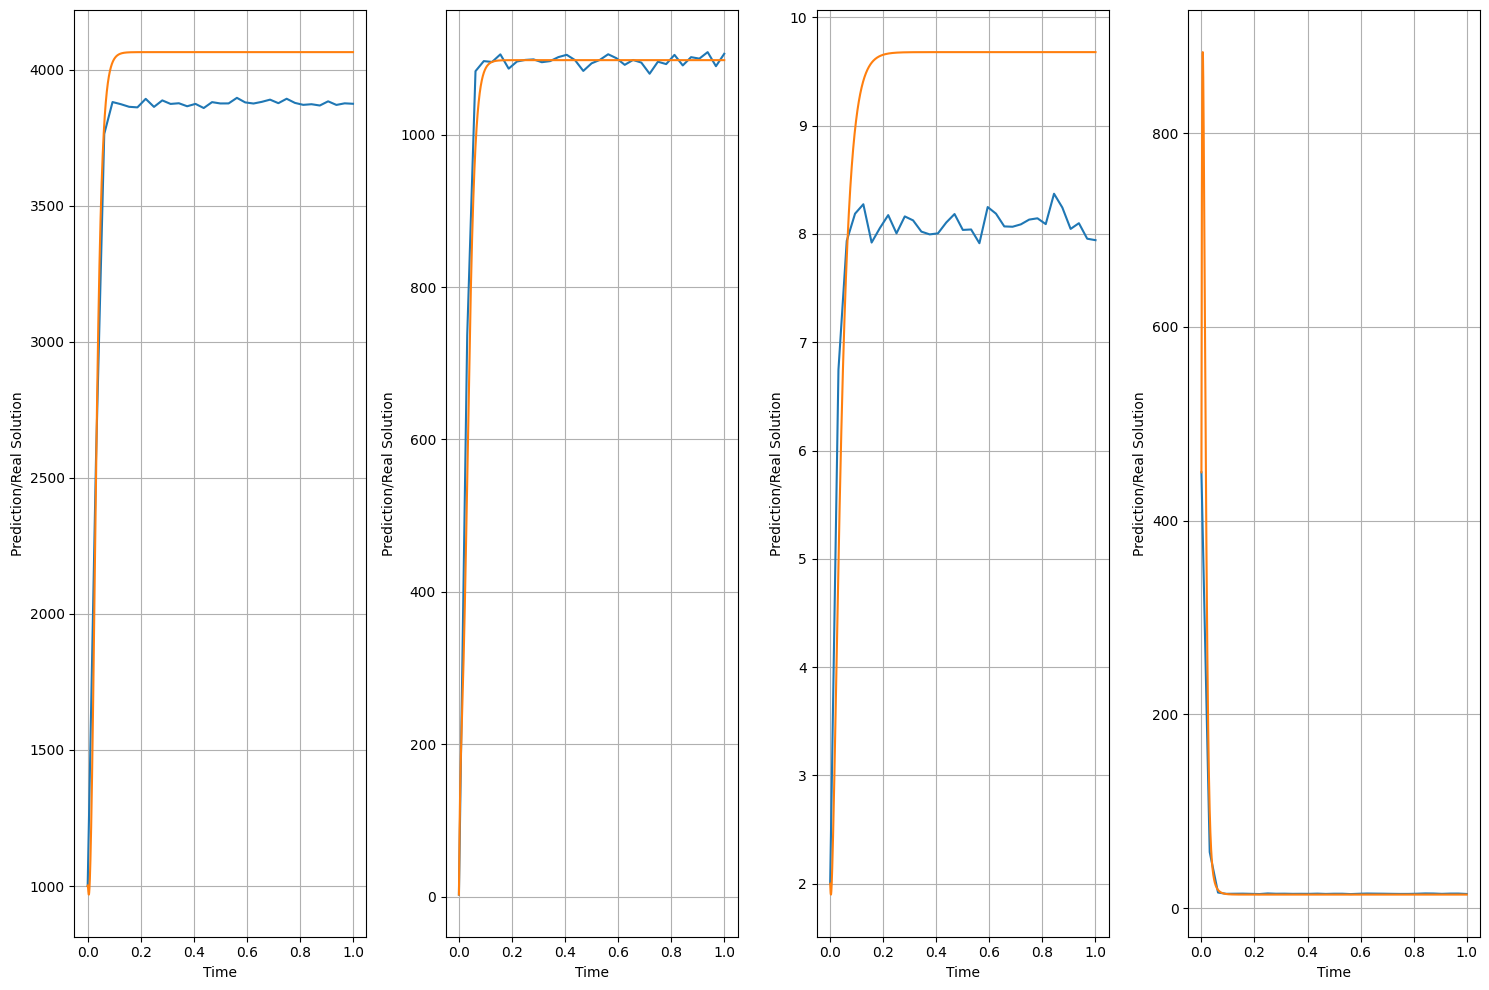

In [31]:
x1 = np.linspace(0, 1, num=33)
x2 = np.linspace(0, 1, num=32003)
predicted = np.concatenate((prior_sample_test(Initial)[:,2:],x_sim_s),axis=0)
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
ax = ax.flat

for i in range(4):
    ax[i].plot(x1,predicted[:,i])
    ax[i].plot(x2,Test_data['Real_Time_Series'][i])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Prediction/Real Solution")
    ax[i].grid(True)
    #ax[i].legend()

plt.tight_layout()
plt.show()

# Toy Example

In [35]:
def Setting_Params(Prev_Step_out):
  new_prior = np.zeros((6,Prev_Step_out.shape[1]))
  for i in range(Prev_Step_out.shape[1]):
    if i == 0:
      new_prior[0][i] = Prev_Step_out[0][i+1]
      new_prior[1][i] = Prev_Step_out[3][i+1]
    elif i == Prev_Step_out.shape[1]-1:
      new_prior[0][i] = Prev_Step_out[0][i-1]
      new_prior[1][i] = Prev_Step_out[3][i-1]
    else:
      new_prior[0][i] = 0.5*Prev_Step_out[0][i-1] + 0.5*Prev_Step_out[0][i+1]
      new_prior[1][i] = 0.5*Prev_Step_out[3][i-1] + 0.5*Prev_Step_out[3][i+1]
    #print(new_prior[0])
    #print(new_prior[1])
    new_prior[2][i] = Prev_Step_out[0][i]
    new_prior[3][i] = Prev_Step_out[1][i]
    new_prior[4][i] = Prev_Step_out[2][i]
    new_prior[5][i] = Prev_Step_out[3][i]
  return new_prior

In [36]:
N_Cells = 10
Initial_Cells = {}
Initial_Cells['Prior'] = np.ndarray((0,6))
inital_conditions = np.zeros((4,))
for i in range(N_Cells):
  prior = prior_sample(inital_conditions)
  Initial_Cells['Prior'] = np.concatenate((Initial_Cells['Prior'], prior), axis=0)

In [37]:
steps = 50
Changes_In_Time_Pred = np.zeros((10,6,steps))
Changes_In_Time_Sim = np.zeros((10,6,steps))
test_dict = {}
test_dict['training'] = 'False'
Cells = Initial_Cells["Prior"]
Cells_sim = Initial_Cells["Prior"]
for i in tqdm(range(steps)):
  Changes_In_Time_Pred[:,:,i] = Cells
  Changes_In_Time_Sim[:,:,i] = Cells_sim
  test_dict["direct_conditions"] =  tf.convert_to_tensor(
      Cells, dtype=float, dtype_hint=None, name=None
      )
  x_pred = amortizer.sample_parameters(test_dict, n_samples=100, to_numpy = True )
  x_pred = np.squeeze(np.mean(x_pred,axis = 1))
  x_pred_t = np.transpose(x_pred)
  x_sim = np.zeros((10,4))
  for p in range(N_Cells):
    x_sim[p] = Nonlinear_Solver(Cells_sim[p],T)[:,-1]
  x_sim_t = np.transpose(x_sim)
  next_step_prior = Setting_Params(x_pred_t)
  Cells = np.transpose(next_step_prior)

  next_step_prior = Setting_Params(x_sim_t)
  Cells_sim = np.transpose(next_step_prior)

100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


# Plots for toy example

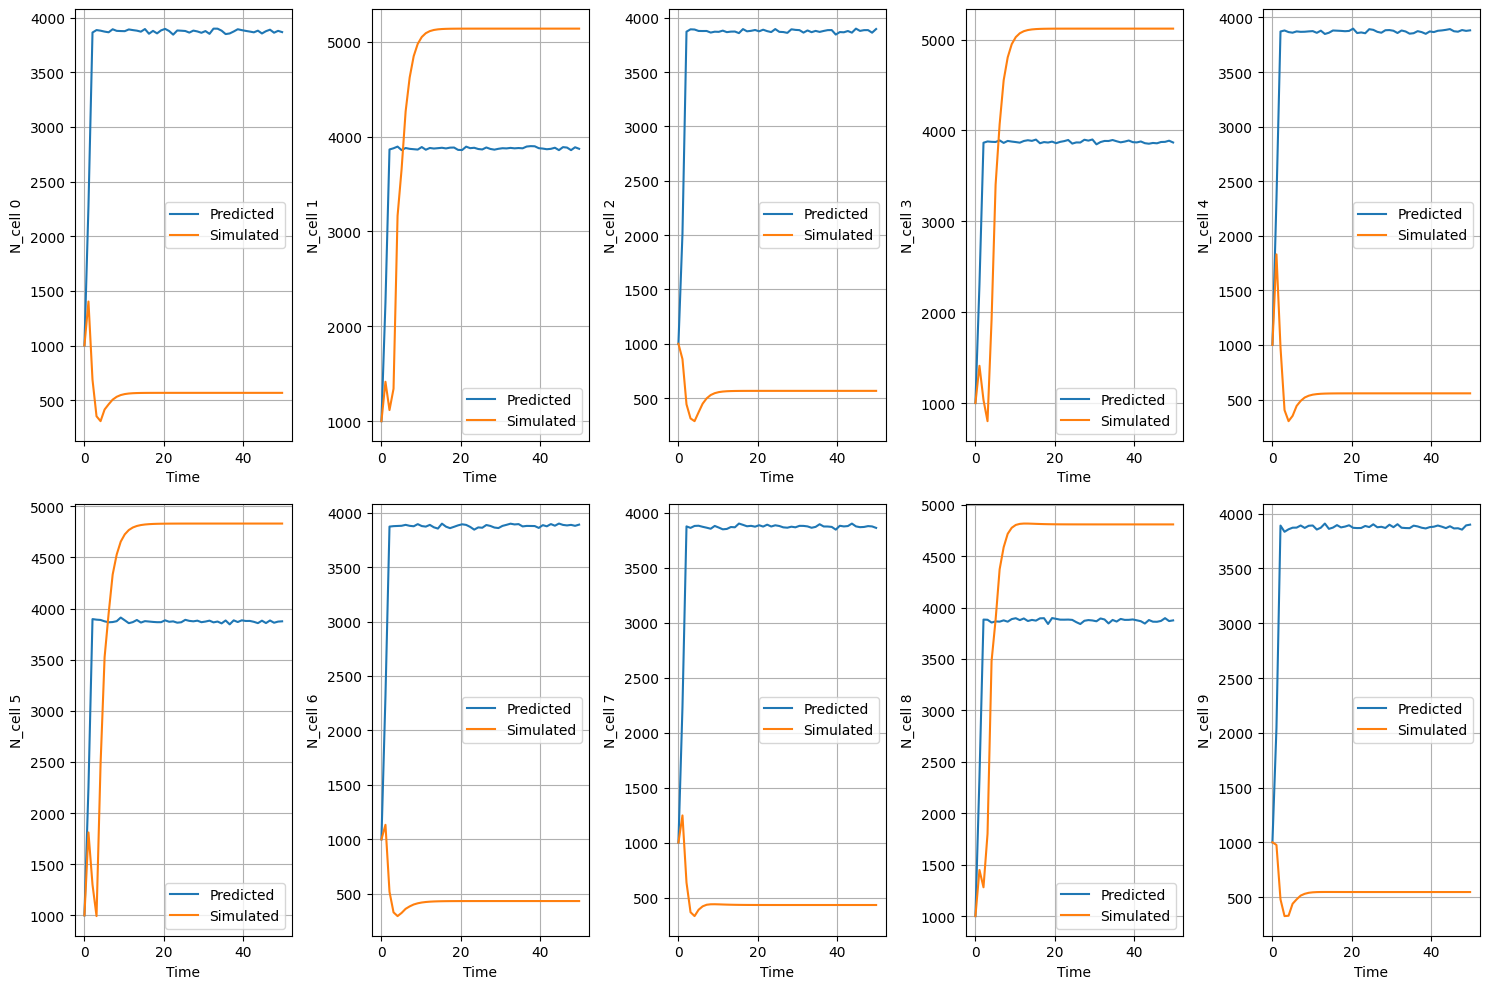

In [38]:
#Plots for N

x1 = np.linspace(0, 50)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][2] , label = "Predicted")
    ax[i].plot(x1,sim[i][2], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"N_cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

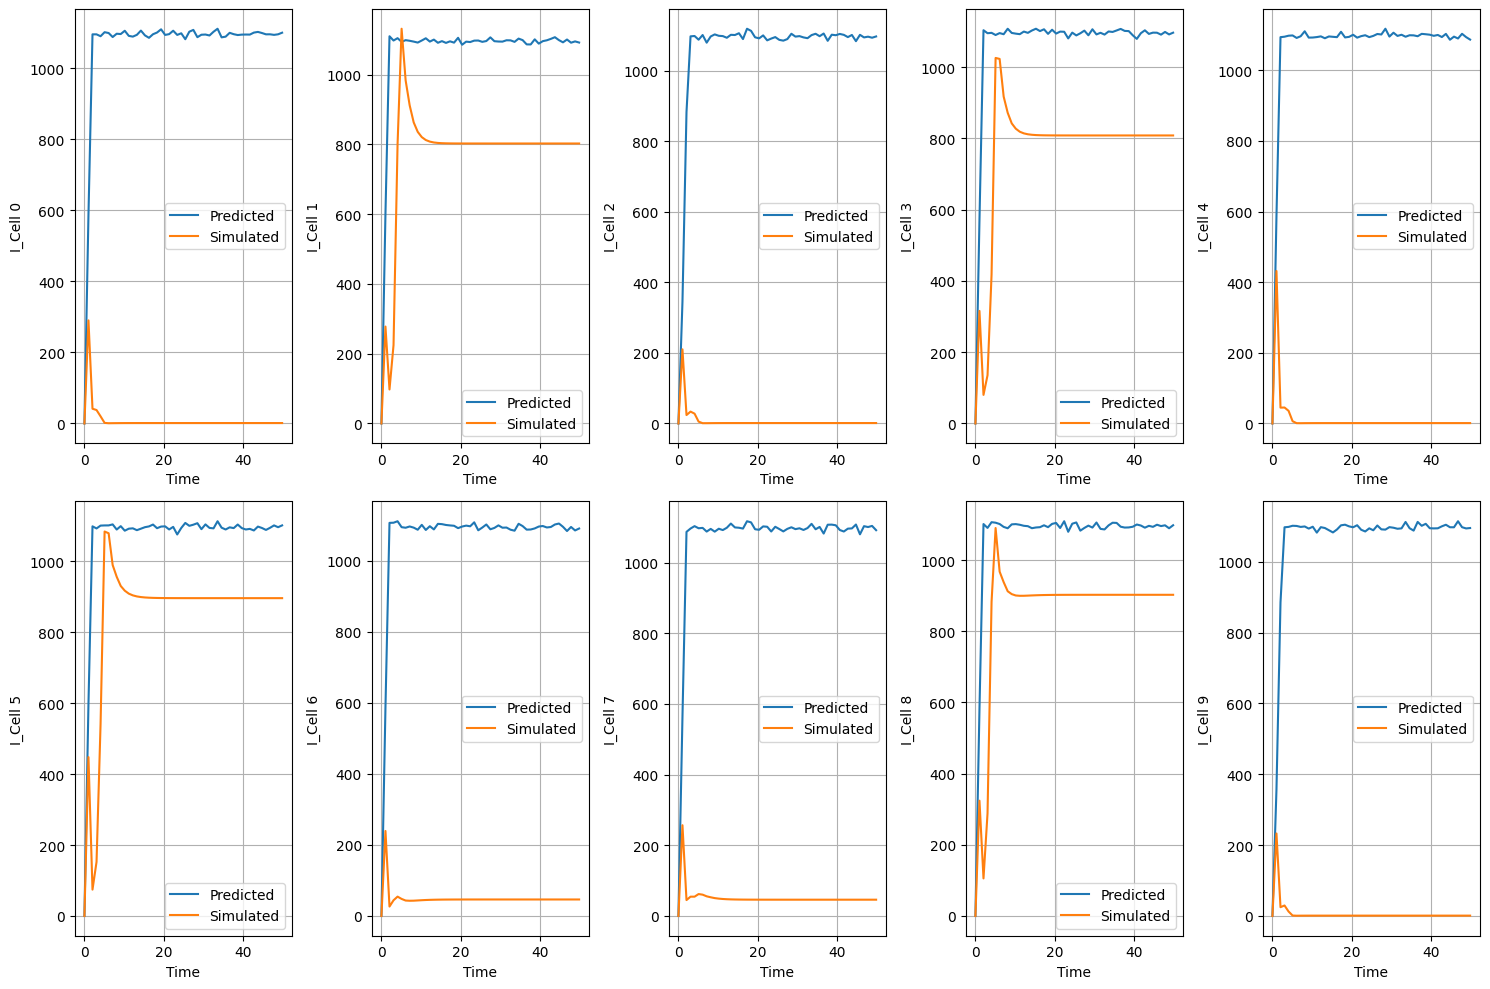

In [39]:
#Plots for I

x1 = np.linspace(0, 50)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][3] , label = "Predicted")
    ax[i].plot(x1,sim[i][3], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"I_Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

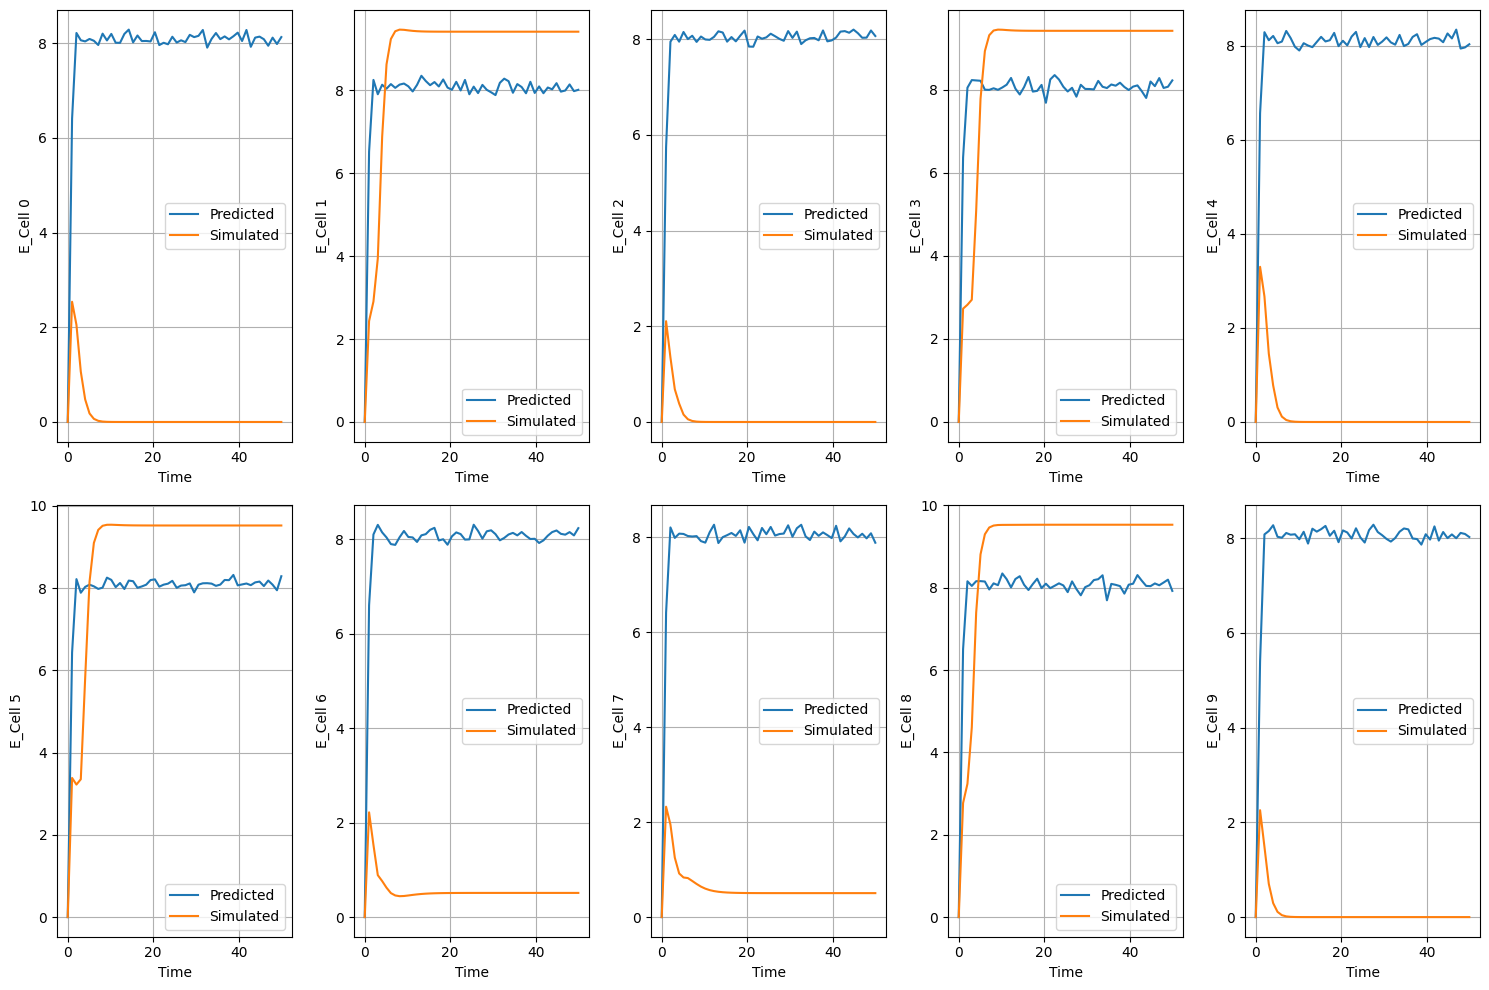

In [40]:
#Plots for E

x1 = np.linspace(0, 50)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][4] , label = "Predicted")
    ax[i].plot(x1,sim[i][4], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"E_Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

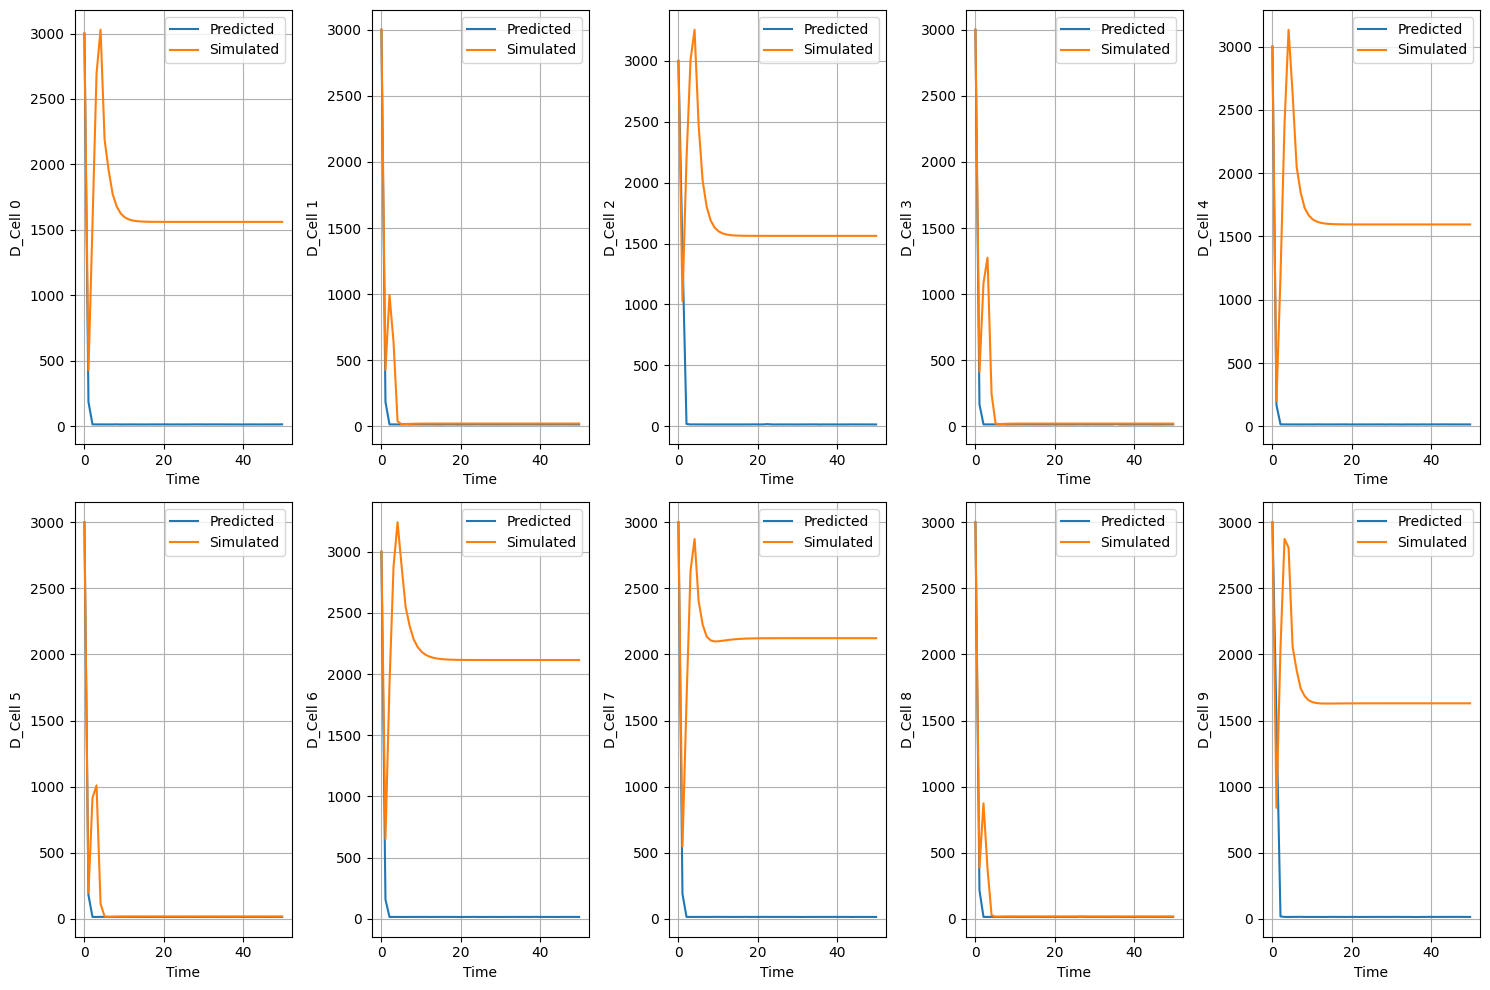

In [41]:
#Plots for D

x1 = np.linspace(0, 50)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][5] , label = "Predicted")
    ax[i].plot(x1,sim[i][5], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"D_Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

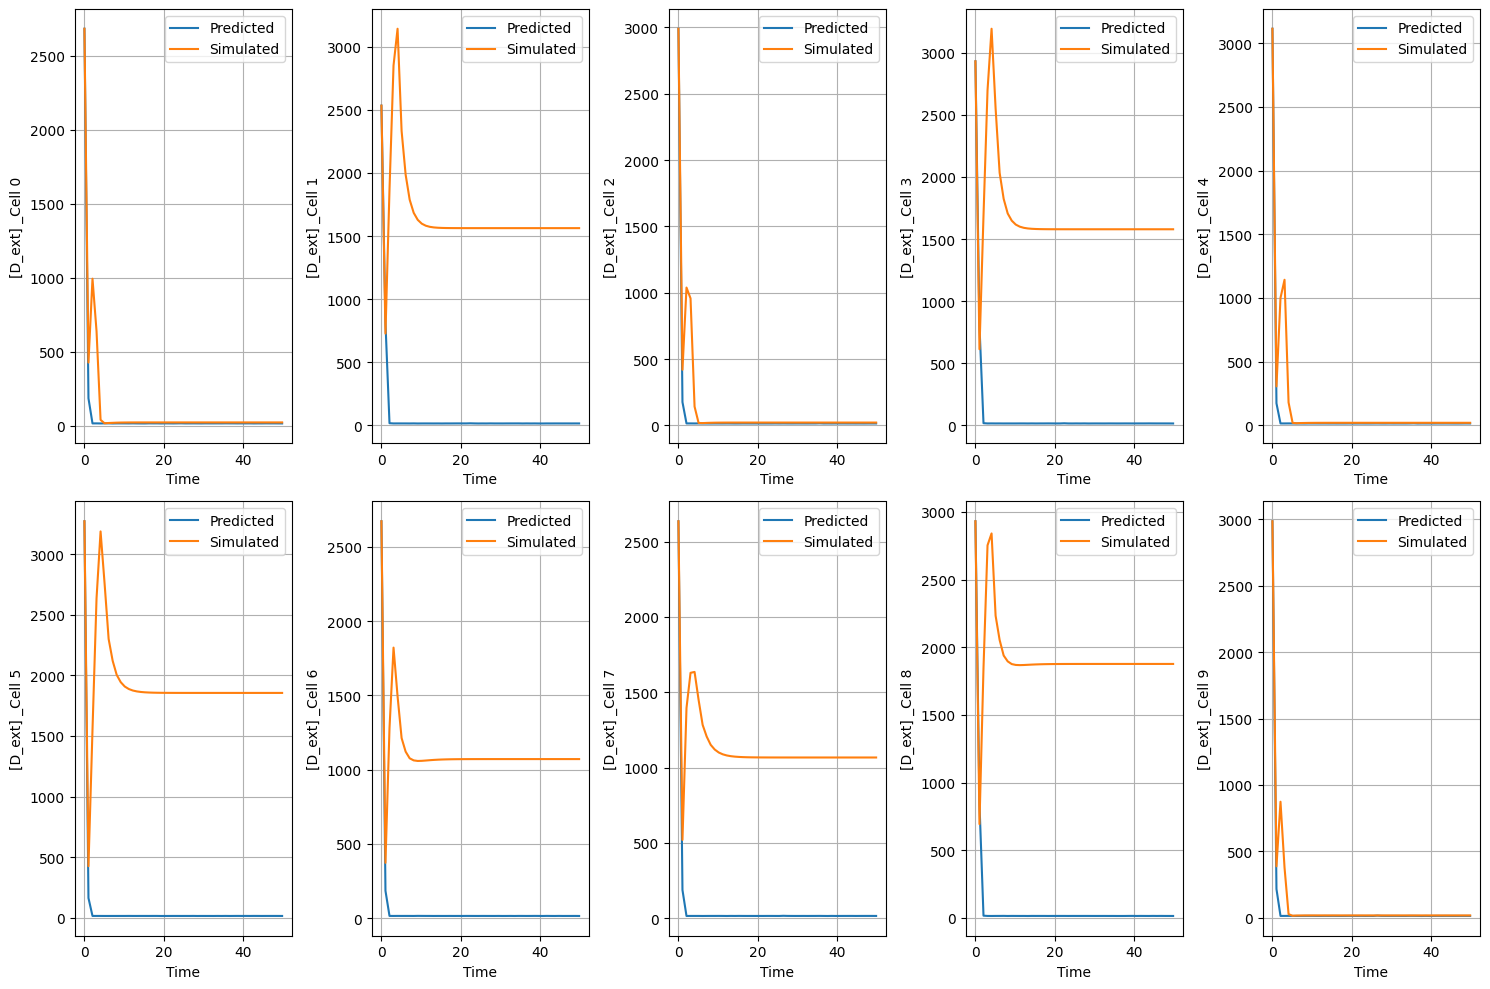

In [42]:
#Plots for D_ext

x1 = np.linspace(0, 50)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][1] , label = "Predicted")
    ax[i].plot(x1,sim[i][1] , label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"[D_ext] _Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()